In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lng
import subprocess
import os
import struct
import time
import math

# read data and preprocessing

In [2]:
def readImages(file):
    with open(file.split('.')[0], 'rb') as f:
        magic_num, size = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(),dtype=np.dtype(np.uint8).newbyteorder(">"))
        data = data.astype(np.float32)
        data = data.reshape((size, rows * cols))
    return data

def readLabels(file):
    with open(file.split('.')[0], 'rb') as f:
        magic_num, size = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(),dtype=np.dtype(np.uint8).newbyteorder(">"))
        data = data.reshape((size))
    data = np.array([data[i]//5 for i in range(size)])
    data_ohe = np.zeros((data.shape[0], data.max()+1))
    data_ohe[np.arange(data.shape[0]), data] = 1
    return data_ohe, data

x_train = readImages('train-images-idx3-ubyte')
y_train_ohe, y_train = readLabels('train-labels-idx1-ubyte')
x_test = readImages('t10k-images-idx3-ubyte')
y_test_ohe, y_test = readLabels('t10k-labels-idx1-ubyte')
# x-normalize data
x_train = (x_train-np.mean(x_train))/np.std(x_train)
# concatenate 1 to the end
c = np.array([[1 for i in range(60000)]])
ct = np.array([[1 for i in range(10000)]])
x_train = np.concatenate((x_train, c.T), axis=1)
x_test = np.concatenate((x_test, ct.T), axis=1)


In [3]:
print(y_test)

[1 0 0 ... 0 1 1]


# baseline

In [ ]:
def minibatch_SGD(B, itrs, eta, train_x, train_y, x_test, y_test):
    weights, v_weights, loss, te_loss = [], [], [], []
    W = np.zeros((785,2)) ## Baseline
    interv = np.linspace(1,itrs,num=5)
    interv = [math.floor(i) for i in interv]
    te_err_list, tr_err_list = [], []
    for i in range(itrs): 
        r = np.random.choice(len(train_x), size=B, replace=False)
        X = train_x[r,:] 
        Y = train_y[r]
        # update weights: W
        g = W.T.dot(X.T) # 2 x B
        g = X.T.dot(g.T) - (X.T.dot(Y)) # 785 x 2
        W -= eta/B*g
        weights.append(W)
        if i in interv:
            print("Num iters: {}".format(i))
        train_bool = X@W 
        test_bool = x_test@W 
        tr_err = 1-((np.argmax(train_bool, axis=1) == np.argmax(Y,axis=1)).sum()) / Y.shape[0]
        te_err = 1-((np.argmax(test_bool, axis=1) == np.argmax(y_test,axis=1)).sum()) / y_test.shape[0] 
        tr_err_list.append(100*tr_err)
        te_err_list.append(100*te_err)
        loss.append(0.5*np.square(lng.norm(Y - train_bool)/B)) 
        te_loss.append(0.5*np.square(lng.norm(y_test - test_bool)/10000)) 
    return weights, loss, tr_err_list, te_loss, te_err_list

In [ ]:
iters = 300
w, l, tr_err_list, te_l, te_err_list = minibatch_SGD(100, iters, 10**-11, x_train, y_train_ohe, x_test, y_test_ohe)
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(iters),tr_err_list,label='Training Misclass Rate')
plt.plot(np.arange(iters),te_err_list,label='Test Misclass Rate')
plt.ylabel('Misclassification Rate (%)')
plt.xlabel('Iteration Count')
plt.legend()
plt.savefig('part2')
plt.show()
# plt.plot(np.linspace(1,iters,num=iters),l,label="Training Loss")
# plt.plot(np.linspace(1,iters,num=iters),te_l,label="Test Loss")
# plt.ylabel('Quadratic Loss')
# plt.xlabel('Iteration Count')
# plt.legend()
# plt.show()

In [ ]:
print(y_test)

# neural net; quadratic loss

In [7]:
def relu(x):
    return np.maximum(x,0)

def QL_weights(W,V,x,y,eta): # quadratic loss
    # update weights: W
#     print("V: {}".format(V.shape))
#     print("W.T: {}".format((W.T).shape))
#     print("x.T: {}".format((x.T).shape))
#     print("y: {}".format(y.shape))
    t = relu(W.T@x)
    d_relu = np.where(t > 0,1,0)
    est_y = V@t # spits out scalar value
    res = est_y-y
#     print("res: {}".format(res))
    W -= (eta*res*np.multiply(V.T,d_relu)@x.T).T # hadamard product
    V -= (eta*res*t).T
    return W, V

In [8]:
def nn_SGD(B, itrs, eta, train_x, train_y, x_test, y_test, epochs, k):
    W_QL = np.random.normal(0, 1/k, ((785,k))) 
    V_QL = np.random.normal(0, 1/100, ((1,k))) 
    interv = [math.floor(i) for i in np.linspace(1,itrs,num=5)]
    te_err_list, tr_err_list = [], []
    tr_err, te_err = 0,0
    count = 1

    for epoch in range(epochs):
        print("Epoch: {}".format(epoch))
        r = np.random.choice(np.arange(60000),itrs)
        for i in range(itrs):  
            X = np.array(train_x[r[i],:]).reshape((785,1)) # NN
            Y = train_y[r[i]]
            W_QL, V_QL = QL_weights(W_QL,V_QL,X,Y,eta) # quadratic loss
#             W_LL, V_LL = LL_weights(W_LL, V_LL) # logistic loss
            if i in interv:
                print("Num iters: {}".format(i))
            train_bool = V_QL@(relu(W_QL.T@X))
            train_bool = np.where(train_bool >= 0.5, 1, 0)
            if train_bool != Y: # one example at at time
                tr_err += 1
            if count % 1000 == 0:
                tr_err_list.append(100*tr_err/count)
                test_output = V_QL@(relu(W_QL.T@x_test.T)) # 1x10k
                test_output = np.where(test_output >= 0.5, 1, 0)
                te_err = 1 - ((test_output == y_test).sum())/10000
                te_err_list.append(100*te_err)
            count += 1
    return tr_err_list, te_err_list

Epoch: 0
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 1
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 2
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 3
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 4
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000


/Users/audrey_der/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/audrey_der/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


Epoch: 0
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 1
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 2
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 3
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 4
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 0
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 1
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 2
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 3
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000
Epoch: 4
Num iters: 1
Num iters: 15000
Num iters: 30000
Num iters: 45000


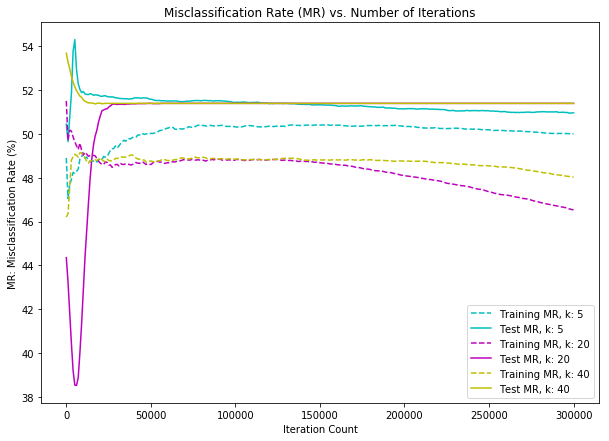

In [9]:
fig = plt.figure(figsize=(10,7))
itrs = 60000 
eta = 10**-6
epochs = 5
colors = ['c','m','y']
j = 0
for k in [5,20,40]:
    tr_mr, te_mr = nn_SGD(1, itrs, eta, x_train, y_train, x_test, y_test, epochs, k)
    plt.plot(np.linspace(0,300000,num=itrs*epochs/1000), tr_mr, color=colors[j], linestyle='--', label = 'Training MR, k: {}'.format(k))
    plt.plot(np.linspace(0,300000,num=itrs*epochs/1000), te_mr, color=colors[j], label='Test MR, k: {}'.format(k))
    plt.ylabel('MR: Misclassification Rate (%)')
    plt.xlabel('Iteration Count')
    plt.title('Misclassification Rate (MR) vs. Number of Iterations')
    j += 1
plt.legend()
plt.show()

In [ ]:
print(te_mr)